In [1]:
#this notbook is for testing out little bits of code that could be useful in the overall pipeline. API calls, reading alignments, running other software stuff etc
#I've added some comments in cells for some small tasks we might need to do often. It would be good to have some sanity check outputs for each task to make sure the code is working


In [9]:
#setup folders
import os
import glob
folders = [ 'alns' , 'templates' , 'TensorflowModels' ]
clear = False
for path in folders:
    if not os.path.isdir(path):
        os.mkdir(path)
    if clear == True:
        files = glob.glob(path+'*.pdb')
        for f in files:
            os.remove(f)

In [7]:
#dl pdb files
#this uses wget to download individual pdb files and stores the paths
import wget
import glob
import time
models = '1ok8 1oan'.split()

dl_url = 'http://files.rcsb.org/download/'
dl_url_err = 'http://files.rcsb.org/download/'
structs = {}
already = glob.glob( './templates/*.pdb' )
print(already)

#pull complexes
for m in models:
    structfile = './templates/'+m.upper().strip()+'.pdb'
    if structfile not in already:
        print(m)
        time.sleep(1)
        try:
            wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
            structs[m] = structfile
        except:
            try:
                wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
                structs[m] = structfile
            except:
                print('err', m )
    else:
        structs[m.strip()] = structfile

print(structs)
        

['./templates/1OAN.pdb', './templates/1OK8.pdb']
{'1ok8': './templates/1OK8.pdb', '1oan': './templates/1OAN.pdb'}


In [8]:
#grab sequences in AA from the PDB files 

from Bio import Alphabet
from Bio.SeqUtils import seq1
from Bio.PDB.PDBParser import PDBParser

parser = PDBParser()
#converter from 3 letter codes to 1 letter
letter3 = Alphabet.ThreeLetterProtein.letters
converter = { l.upper(): seq1(l) for l in letter3 }
structseqs={}
with open( 'structs.fast' , 'w')as fastout:
    for s in structs:
        Structure = PDBParser().get_structure(s, structs[s])
        for model in Structure:
            for chain in model:
                res = chain.get_residues()
                seq =  ''.join([ converter[r.get_resname()] for r in res if r.get_resname() in converter ] )
                fastout.write('>' + s + '|'+ chain.id +'\n')
                fastout.write(str( seq ) +'\n'  )
                structseqs[ s + '|'+ chain.id ] = seq

                
                

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6846.
  PDBConstructionWarning,
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6861.
  PDBConstructionWarning,
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6875.
  PDBConstructionWarning,
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6895.
  PDBConstructionWarning,


In [ ]:
#proto for a function that opens an external program. pretty useful since we're using a lot of 3rd party tools
import subprocess 
import shlex

def runclustalo( infile , runIdentifier, path = 'clustalo' , outdir='./', args = '' , verbose = False):
    if verbose == True:
        print( infile , runIdentifier , path , outdir )
    #i usually use filenames that reflect what the pipeline has done until that stap
    outfile= outdir+runIdentifier+infile+".aln.fasta"
    
    #here we write the command as a string using all the args
    args = path + ' -i '+  infile  +' -o '+ outfile + ' ' +args
    args = shlex.split(args)
    if verbose == True:
        print(args)
    p = subprocess.Popen(args )
    #return the opened process and the file it's creating
    
    #we can also use the communicate function later to grad stdout if we need to 
    return p , outfile

    

In [ ]:
# add the amino acid sequence from the 3d structure to an aligment
# run clustalo merge



In [3]:
#read aln 2 numpy matrix
import numpy
from Bio import AlignIO

alnfile = ''
msa = AlignIO.read(alnfile , format = 'fasta')
align_array = np.array([ list(rec.upper())  for rec in msa], np.character)

In [33]:
#run dssp on a struct
import subprocess 
import shlex

def rundssp( infile , runIdentifier, path = 'dssp' , outdir='./', args = '' , verbose = False):
    if verbose == True:
        print( infile , runIdentifier , path , outdir )
    #i usually use filenames that reflect what the pipeline has done until that stap
    outfile= outdir+runIdentifier+infile+".dssp"
    
    #here we write the command as a string using all the args
    args = path + ' -i '+  infile  +' -o '+ outfile + ' ' +args
    args = shlex.split(args)
    if verbose == True:
        print(args)
    p = subprocess.Popen(args )
    #return the opened process and the file it's creating
    
    #we can also use the communicate function later to grad stdout if we need to 
    return p , outfile



#not working at the moment due to permissions for some reason...

for s in structs:
    print(structs[s])
    p, outdssp = rundssp( structs[s] , 'test' , outdir = './templates/' , verbose = True)
    p.wait()
    

In [39]:
#dssp to pandas
import pandas as pd
def dssp2pandas(dsspstr):
    #read the dssp file format into a pandas dataframe
    start = False
    lines = {}
    count = 0
    for l in dsspstr.split('\n'):
        if '#' in l:
            start = True
        if start == True:
            if count > 0:
                lines[count] = dict(zip(header,l.split()))
            else:
                header = l.split()
            count +=1
    df = pd.DataFrame.from_dict( lines , orient = 'index')
    return df
    
dssps= glob.glob( './templates/*.dssp')
for dssp in dssps:
    with open( dssp , 'r') as dsspin:
        df = dssp2pandas( dsspin.read() )
        print(df)

       # RESIDUE AA STRUCTURE BP1 BP2  ACC   N-H-->O   O-->H-N       TCO  \
1      1       1  A         M   >   0    0       0.0  151,-2.8        0,   
2      2       2  A         R   T   3    +        33  140,-0.2  495,-0.0   
3      3       3  A         a   T   >   S+         0  139,-0.2    3,-2.5   
4      4       4  A         I   T   <   S+         1   -3,-0.6  493,-0.4   
5      5       5  A         G   T   3   S+        20   -2,-0.6    2,-0.4   
..   ...     ... ..       ...  ..  ..  ...       ...       ...       ...   
785  785     390  B         N   E  -C  772  -13,-0.2    2,-0.3  -15,-0.0   
786  786     391  B         W   E  -C  771  -15,-2.3  -15,-1.0   -2,-0.2   
787  787     392  B         F   E  -C  770   -2,-0.3    2,-0.3  -17,-0.2   
788  788     393  B         K   E   C  769  -19,-2.1  -19,-1.8   -2,-0.4   
789  789     394  B         K   0   0  192  -21,-0.2   -2,-0.0    -0.020   

        KAPPA     ALPHA               PHI          PSI   X-CA   Y-CA   Z-CA  
1        

In [ ]:
#run protFet on a sequence




/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6846.
  PDBConstructionWarning,
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6861.
  PDBConstructionWarning,
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6875.
  PDBConstructionWarning,
/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6895.
  PDBConstructionWarning,


1ok8


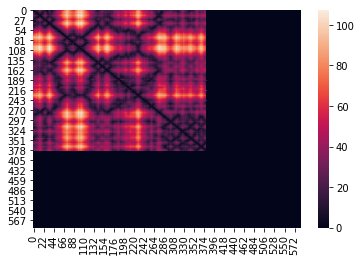

1oan


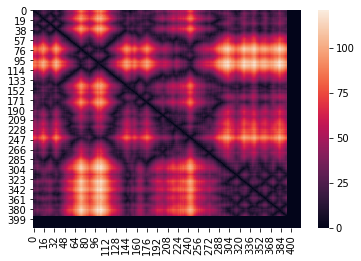

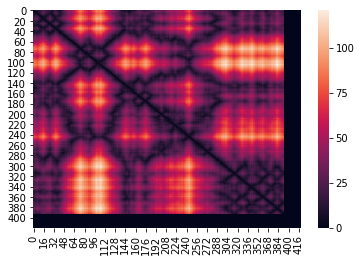

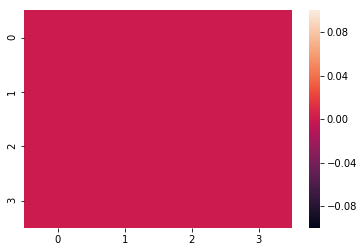

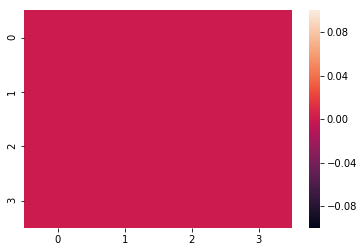

In [17]:
#pdb 2 distmat

from Bio import Alphabet
from Bio.SeqUtils import seq1
from Bio.PDB.PDBParser import PDBParser
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

distances = {}
for s in structs:
    Structure = PDBParser().get_structure(s, structs[s])
    
    distances[s] = {}
    for model in Structure:
        
        for chain in model:
            res = [r for r in chain.get_residues()]
            distmat = [ [res2['CA'] - res1['CA'] if 'CA' in res1 and 'CA' in res2 and i > j else 0 for i,res1 in enumerate(res)] for j,res2 in enumerate(res)]
            distmat = np.array(distmat)
            distmat+= distmat.T
            distances[s][chain] = distmat
            
for s in distances:
    print(s)
    for c in distances[s]:
        sns.heatmap(distances[s][c])
        plt.show()


In [7]:
#preparing the output space

import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler,  Normalizer , MinMaxScaler , RobustScaler
from sklearn.decomposition import PCA

#fft ndim tools. transforms the output distance matrices into a set of pca components derived from the 
#fourier spectrum of the input

#Ndimensional robust scaler for arrays


class NDSRobust(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = RobustScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def inverse_transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.inverse_transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X


#ndimensional PCA for arrays

class NDSPCA(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = PCA(copy = True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        self.explained_variance_ratio_ = self._scaler.explained_variance_ratio_
        self.components_ =self._scaler.components_
        
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        
        return X
    
    def inverse_transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.inverse_transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X
    

def fit_y( y , components = 300 , FFT = False ):
    if FFT == True:
        y = np.stack([ np.fft.rfft2(y[i,:,:]) for i in range(y.shape[0])] )
        print(y.shape)
        y =  np.hstack( [ np.real(y) , np.imag(y)]  )
    print(y.shape)
    ndpca = NDSPCA(n_components=components)
    ndpca.fit(y)
    print('explained variance')
    print(np.sum(ndpca.explained_variance_ratio_))
    y = ndpca.transform(y)
    scaler0 = RobustScaler( )
    scaler0.fit(y)
    return scaler0, ndpca 

def transform_y( y, scaler,ndpca , FFT = False ):
    if FFT == True:
        y = np.stack([ np.fft.rfft2(y[i,:,:]) for i in range(y.shape[0])] )
        print(y.shape)
        y =  np.hstack( [ np.real(y) , np.imag(y)]  )
    y = ndpca.transform(y)
    print(y.shape)
    y = scaler0.transform(y)
    
    return y 

def inverse_transform_y( y , scaler, ndpca , FFT=False):
    
    y = scaler0.inverse_transform(y)
    y = ndpca.inverse_transform(y)

    if FFT == True:
        split = int(y.shape[1]/2)
        y = np.stack([ np.fft.irfft2(y[i,:split,:] + 1j*y[i,split:,:]) for i in range(y.shape[0]) ] )
                  
    return y


In [ ]:
#preparing the input 

#read an aln

#use linear representation of each sequence

#w or without gaps

#compile 3d mat of nseq x columns x properties

#fft to 3d mat of components

#clip higher freqs


